In [1]:
import numpy as np
import nengo
import nengo_spa as spa  # Tutorial completed in nengo_spa, not legacy spa!
import matplotlib.pyplot as plt

rng = np.random.RandomState(0) # random number generator

In [14]:
d = 16
vocab = spa.Vocabulary(d, pointer_gen=rng)

# Adding semantic pointers to the vocabulary
vocab.populate("CIRCLE; SQUARE; BLUE; RED")

# Create the spa.Network to which we can add SPA objects
with spa.Network(label="Question Answering with Memory", vocabs=[vocab]) as model:
    A = spa.State(d)
    B = spa.State(d)
    C = spa.State(d)
    D = spa.State(d)
    E = spa.State(d)
    memory = spa.State(d, feedback=1)

    A * B >> D
    D >> memory
    memory * ~C >> E

    # Function for providing color input
    def color_input(t):
        if t < 0.25:
            return "RED"
        elif t < 0.5:
            return "BLUE"
        return spa.semantic_pointer.Zero(d)

    # Function for providing shape input
    def shape_input(t):
        if t < 0.25:
            return "CIRCLE"
        elif t < 0.5:
            return "SQUARE"
        return spa.semantic_pointer.Zero(d)

    # Function for providing the cue
    def cue_input(t):
        if t < 0.5:
            return spa.semantic_pointer.Zero(d)
        sequence = [spa.semantic_pointer.Zero(d), "CIRCLE", "RED", spa.semantic_pointer.Zero(d), "SQUARE", "BLUE"]
        idx = int(((t - 0.5) // (1.0 / len(sequence))) % len(sequence))
        return sequence[idx]

    # Inputs
    spa.Transcode(color_input,output_vocab=vocab) >> A
    spa.Transcode(shape_input,output_vocab=vocab) >> B
    spa.Transcode(cue_input,output_vocab=vocab) >> C

    # Probes
    pE = nengo.Probe(E.output, synapse=0.03)

In [15]:
with nengo.Simulator(model) as sim:
    sim.run(1.5)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

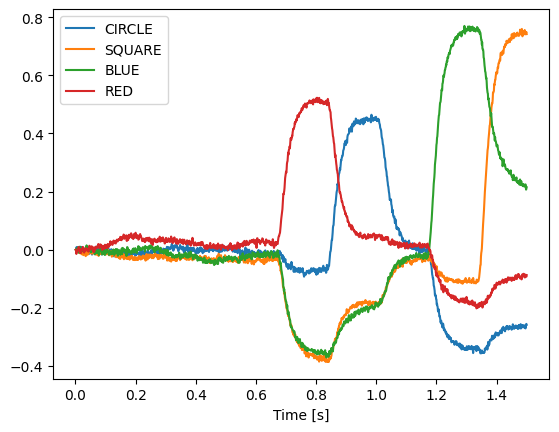

In [16]:
plt.plot(sim.trange(), spa.similarity(sim.data[pE], vocab))
plt.xlabel("Time [s]")
plt.legend(vocab, loc="best")